## Testing the accuracy and efficiency of interpolation via xarray

### Add paths to run locally or off Cheyenne or Casper 

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/CESM2_analysis')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/CESM2_analysis/Common/')
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, share_ylims,
    to_png
    )

from cloud_metric import Cloud_Metric
from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Check running location and adjust working directory appropriately.

In [2]:
host = os.uname()[1]
if 'jupyter' in host.split('-'): # Check if running on NIRD through the Jupyter Hub
    print('Running through MC2 Jupyter Hub')
    model_dir = '/mnt/mcc-ns9600k/jonahks/'
    os.chdir(model_dir)
    
elif 'casper' in host: # Check if running on NIRD through the Jupyter Hub
    print('Running through CISL Casper')
    obs_dir = '/glade/u/home/jonahshaw/w/obs/'
#     model_dir = '/glade/p/cesm/pcwg/jenkay/COSP/'
    os.chdir(obs_dir)
    
elif 'r6i6' in host: # Check if running on NIRD through the Jupyter Hub
    print('Running through CISL Cheyenne')
    obs_dir = '/glade/u/home/jonahshaw/w/obs/'
#     model_dir = '/glade/p/cesm/pcwg/jenkay/COSP/'
    os.chdir(obs_dir)

else:  # Assume that we're running on a local machine and mounting NIRD
    print('Running on %s, attempting to mount ns9600k/jonahks/ from NIRD' % str(host))
    os.system('fusermount -zu ~/drivemount/')  # unmount first
    os.system('sshfs jonahks@login.nird.sigma2.no:"p/jonahks/" ~/drivemount/')    # Calling mountnird from .bashrc doesn't work
    os.chdir('/home/jonahks/drivemount/')
    save_dir = '~/DATAOUT/'
    save_to = os.path.expanduser(save_dir)

output_dir = '/glade/u/home/jonahshaw/figures/'
obs_dir = '/glade/u/home/jonahshaw/w/obs/'
model_dir = '/glade/p/cesm/pcwg/jenkay/COSP/'
# case_dir = '/glade/p/cesm/pcwg/jenkay/COSP/cesm21/' 

# Check that each important directory can be accessed:    
access_paths = os.path.exists(output_dir) and os.path.exists(model_dir) #and os.path.exists(conv_dir)
print('Can access all directory paths:', access_paths)

Running through CISL Casper
Can access all directory paths: True


In [11]:
os.listdir()

['.ipynb_checkpoints', 'CLOUDSAT', 'CALIPSO']

In [3]:
os.chdir('CALIPSO/GOCCP/2Ddata/')

In [15]:
os.listdir()

['2006',
 '2014',
 '2015',
 '2010',
 '2011',
 '2012',
 'remapweights.nc',
 '2013',
 '2007',
 '1.25x0.9_interpolation',
 '2008',
 '2009']

In [6]:
raw_goccp = xr.open_dataset('2006/MapLowMidHigh_Phase330m_200606_avg_CFMIP2_sat_3.1.2.nc')
old_interp = xr.open_dataset('1.25x0.9_interpolation/2006/MapLowMidHigh_Phase330m_200606_avg_CFMIP2_sat_3.1.2.nc')
cesm2_09res = xr.open_dataset('%s/cesm21/cesm2p1_B1850_COSP2_PCWG/atm/hist/%s' % (model_dir,'cesm2p1_B1850_COSP2_PCWG.cam.h0.0003-05.nc'))

In [28]:
os.listdir('%s/cesm21/cesm2p1_B1850_COSP2_PCWG/atm/hist' % model_dir)

['cesm2p1_B1850_COSP2_PCWG.cam.h0.0002-09.nc',
 'cesm2p1_B1850_COSP2_PCWG.cam.h0.0002-04.nc',
 'cesm2p1_B1850_COSP2_PCWG.cam.h0.0001-01.nc',
 'cesm2p1_B1850_COSP2_PCWG.cam.h0.0011-11.nc',
 'cesm2p1_B1850_COSP2_PCWG.cam.h0.0011-03.nc',
 'cesm2p1_B1850_COSP2_PCWG.cam.h0.0009-06.nc',
 'cesm2p1_B1850_COSP2_PCWG.cam.h1.0010-01-01-00000.nc',
 'cesm2p1_B1850_COSP2_PCWG.cam.h0.0001-02.nc',
 'cesm2p1_B1850_COSP2_PCWG.cam.h0.0007-07.nc',
 'cesm2p1_B1850_COSP2_PCWG.cam.h0.0004-09.nc',
 'cesm2p1_B1850_COSP2_PCWG.cam.h0.0002-08.nc',
 'cesm2p1_B1850_COSP2_PCWG.cam.h0.0003-05.nc',
 'cesm2p1_B1850_COSP2_PCWG.cam.h0.0002-01.nc',
 'cesm2p1_B1850_COSP2_PCWG.cam.h0.0007-01.nc',
 'cesm2p1_B1850_COSP2_PCWG.cam.i.0011-01-01-00000.nc',
 'cesm2p1_B1850_COSP2_PCWG.cam.h0.0008-08.nc',
 'cesm2p1_B1850_COSP2_PCWG.cam.h0.0003-10.nc',
 'cesm2p1_B1850_COSP2_PCWG.cam.h0.0006-07.nc',
 'cesm2p1_B1850_COSP2_PCWG.cam.i.0006-01-01-00000.nc',
 'cesm2p1_B1850_COSP2_PCWG.cam.h0.0002-11.nc',
 'cesm2p1_B1850_COSP2_PCWG.cam.h0.0

In [7]:
cesm2_09res

<xarray.Dataset>
Dimensions:         (cosp_dbze: 15, cosp_ht: 40, cosp_scol: 250, cosp_sr: 15, cosp_sza: 5, ilev: 33, lat: 192, lev: 32, lon: 288, nbnd: 2, time: 1)
Coordinates:
  * lat             (lat) float64 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * lon             (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lev             (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev            (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * cosp_scol       (cosp_scol) int32 1 2 3 4 5 6 7 ... 245 246 247 248 249 250
  * cosp_ht         (cosp_ht) float64 1.896e+04 1.848e+04 ... 720.0 240.0
  * cosp_sr         (cosp_sr) float64 -0.495 0.605 2.1 4.0 ... 55.0 70.0 539.5
  * cosp_sza        (cosp_sza) float64 0.0 20.0 40.0 60.0 80.0
  * cosp_dbze       (cosp_dbze) float64 -72.5 -42.5 -37.5 ... 12.5 17.5 50.0
  * time            (time) object 0003-06-01 00:00:00
Dimensions without coordinates: nbnd
Data variables:
    gw              (lat) float64 ...
    hyam            (lev) float64 ...
    hybm            (lev) float64 ...
    P0              float64 ...
    hyai            (ilev) float64 ...
    hybi            (ilev) float64 ...
    cosp_ht_bnds    (cosp_ht, nbnd) float64 ...
    cosp_sr_bnds    (cosp_sr, nbnd) float64 ...
    cosp_dbze_bnds  (cosp_dbze, nbnd) float64 ...
    date            (time) int32 ...
    datesec         (time) int32 ...
    time_bnds       (time, nbnd) object ...
    date_written    (time) |S8 ...
    time_written    (time) |S8 ...
    ndbase          int32 ...
    nsbase          int32 ...
    nbdate          int32 ...
    nbsec           int32 ...
    mdt             int32 ...
    ndcur           (time) int32 ...
    nscur           (time) int32 ...
    co2vmr          (time) float64 ...
    ch4vmr          (time) float64 ...
    n2ovmr          (time) float64 ...
    f11vmr          (time) float64 ...
    f12vmr          (time) float64 ...
    sol_tsi         (time) float64 ...
    nsteph          (time) int32 ...
    ABSORB          (time, lev, lat, lon) float32 ...
    ANRAIN          (time, lev, lat, lon) float32 ...
    ANSNOW          (time, lev, lat, lon) float32 ...
    AODABS          (time, lat, lon) float32 ...
    AODDUST1        (time, lat, lon) float32 ...
    AODDUST2        (time, lat, lon) float32 ...
    AODDUST3        (time, lat, lon) float32 ...
    AODVIS          (time, lat, lon) float32 ...
    AQRAIN          (time, lev, lat, lon) float32 ...
    AQSNOW          (time, lev, lat, lon) float32 ...
    AREI            (time, lev, lat, lon) float32 ...
    AREL            (time, lev, lat, lon) float32 ...
    AWNC            (time, lev, lat, lon) float32 ...
    AWNI            (time, lev, lat, lon) float32 ...
    BURDENBC        (time, lat, lon) float32 ...
    BURDENDUST      (time, lat, lon) float32 ...
    BURDENPOM       (time, lat, lon) float32 ...
    BURDENSEASALT   (time, lat, lon) float32 ...
    BURDENSO4       (time, lat, lon) float32 ...
    BURDENSOA       (time, lat, lon) float32 ...
    CCN3            (time, lev, lat, lon) float32 ...
    CDNUMC          (time, lat, lon) float32 ...
    CFAD_DBZE94_CS  (time, cosp_ht, cosp_dbze, lat, lon) float32 ...
    CFAD_SR532_CAL  (time, cosp_ht, cosp_sr, lat, lon) float32 ...
    CLDHGH          (time, lat, lon) float32 ...
    CLDHGH_CAL      (time, lat, lon) float32 ...
    CLDICE          (time, lev, lat, lon) float32 ...
    CLDLIQ          (time, lev, lat, lon) float32 ...
    CLDLOW          (time, lat, lon) float32 ...
    CLDLOW_CAL      (time, lat, lon) float32 ...
    CLDLOW_CAL_ICE  (time, lat, lon) float32 ...
    CLDLOW_CAL_LIQ  (time, lat, lon) float32 ...
    CLDMED          (time, lat, lon) float32 ...
    CLDMED_CAL      (time, lat, lon) float32 ...
    CLDTOT          (time, lat, lon) float32 ...
    CLDTOT_CAL      (time, lat, lon) float32 ...
    CLDTOT_CAL_ICE  (time, lat, lon) float32 ...
    CLDTOT_CAL_LIQ  (time, lat, lon) float32 ...
    CLD_CAL  

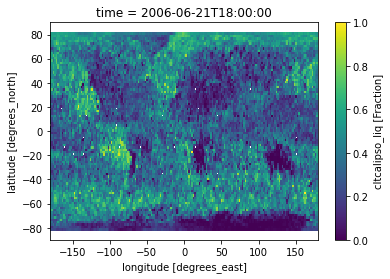

In [8]:
raw_goccp['cltcalipso_liq'].plot()

The CDO interpolation with standard settings is not working very well.

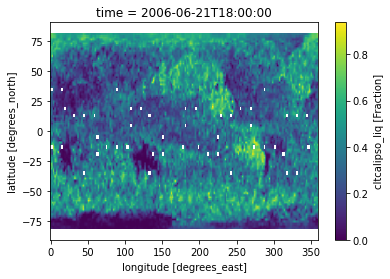

In [21]:
old_interp['cltcalipso_liq'].plot()

### Try interpolation via interp_like

In [38]:
out = raw_goccp['cltcalipso_liq'].interp_like(cesm2_09res['CLDTOT_CAL_LIQ'])

__This doesn't look right...__

In [39]:
out

<xarray.DataArray 'cltcalipso_liq' (time: 1, latitude: 90, longitude: 180)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time       (time) object 0003-06-01 00:00:00
  * longitude  (longitude) float32 -179.0 -177.0 -175.0 ... 175.0 177.0 179.0
  * latitude   (latitude) float32 -89.0 -87.0 -85.0 -83.0 ... 85.0 87.0 89.0
Attributes:
    lon_name:      Total Column Level liq Cloud
    units:         Fraction
    cell_methods:  time: mean

### Try with just the interp method:

In [53]:
test2 = raw_goccp['cltcalipso_liq'].interp(longitude=cesm2_09res['lon'], latitude=cesm2_09res['lat'], method="linear")

__This looks better.__

In [47]:
test2

<xarray.DataArray 'cltcalipso_liq' (time: 1, lat: 192, lon: 288)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time       (time) datetime64[ns] 2006-06-21T18:00:00
    longitude  (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    latitude   (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
Attributes:
    lon_name:      Total Column Level liq Cloud
    units:         Fraction
    cell_methods:  time: mean

__But this is fucked up:__

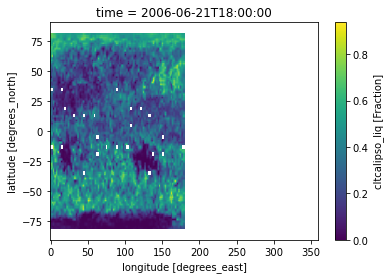

In [49]:
test2.plot()

### Try with just interp method and lon offset:

In [54]:
test3 = raw_goccp['cltcalipso_liq'].interp(longitude=(cesm2_09res['lon']-180), latitude=cesm2_09res['lat'], method="linear")

__This looks better.__

In [55]:
test3

<xarray.DataArray 'cltcalipso_liq' (time: 1, lat: 192, lon: 288)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time       (time) datetime64[ns] 2006-06-21T18:00:00
    longitude  (lon) float64 -180.0 -178.8 -177.5 -176.2 ... 176.2 177.5 178.8
    latitude   (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
Attributes:
    lon_name:      Total Column Level liq Cloud
    units:         Fraction
    cell_methods:  time: mean

__But this is still a little weird:__

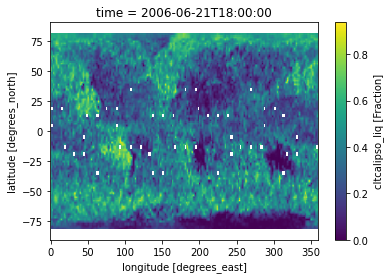

In [56]:
test3.plot()

I think that in order to interp_like effectively, I will have to be able to shift the lat and lon coords so that the domains line up.  

http://xarray.pydata.org/en/stable/generated/xarray.DataArray.assign_coords.html

### Try with just interp like after rotating longitude coordinate:

In [85]:
test4_data = raw_goccp['cltcalipso_liq'].copy()

In [86]:
test4_data.longitude

<xarray.DataArray 'longitude' (longitude: 180)>
array([-179., -177., -175., -173., -171., -169., -167., -165., -163., -161.,
       -159., -157., -155., -153., -151., -149., -147., -145., -143., -141.,
       -139., -137., -135., -133., -131., -129., -127., -125., -123., -121.,
       -119., -117., -115., -113., -111., -109., -107., -105., -103., -101.,
        -99.,  -97.,  -95.,  -93.,  -91.,  -89.,  -87.,  -85.,  -83.,  -81.,
        -79.,  -77.,  -75.,  -73.,  -71.,  -69.,  -67.,  -65.,  -63.,  -61.,
        -59.,  -57.,  -55.,  -53.,  -51.,  -49.,  -47.,  -45.,  -43.,  -41.,
        -39.,  -37.,  -35.,  -33.,  -31.,  -29.,  -27.,  -25.,  -23.,  -21.,
        -19.,  -17.,  -15.,  -13.,  -11.,   -9.,   -7.,   -5.,   -3.,   -1.,
          1.,    3.,    5.,    7.,    9.,   11.,   13.,   15.,   17.,   19.,
         21.,   23.,   25.,   27.,   29.,   31.,   33.,   35.,   37.,   39.,
         41.,   43.,   45.,   47.,   49.,   51.,   53.,   55.,   57.,   59.,
         61.,   63.,   65.,   67.,   69.,   71.,   73.,   75.,   77.,   79.,
         81.,   83.,   85.,   87.,   89.,   91.,   93.,   95.,   97.,   99.,
        101.,  103.,  105.,  107.,  109.,  111.,  113.,  115.,  117.,  119.,
        121.,  123.,  125.,  127.,  129.,  131.,  133.,  135.,  137.,  139.,
        141.,  143.,  145.,  147.,  149.,  151.,  153.,  155.,  157.,  159.,
        161.,  163.,  165.,  167.,  169.,  171.,  173.,  175.,  177.,  179.],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -179.0 -177.0 -175.0 ... 175.0 177.0 179.0
Attributes:
    lon_name:  Longitude
    units:     degrees_east
    axis:      X

In [87]:
test4_data = test4_data.assign_coords({"longitude": (((test4_data.longitude + 180) % 360))})
# test4_data.longitude

In [90]:
cesm2_09res.lon

<xarray.DataArray 'lon' (lon: 288)>
array([  0.  ,   1.25,   2.5 , ..., 356.25, 357.5 , 358.75])
Coordinates:
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Attributes:
    long_name:  longitude
    units:      degrees_east

In [88]:
test4_data

<xarray.DataArray 'cltcalipso_liq' (time: 1, latitude: 90, longitude: 180)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 1.0 3.0 5.0 7.0 ... 353.0 355.0 357.0 359.0
  * latitude   (latitude) float32 -89.0 -87.0 -85.0 -83.0 ... 85.0 87.0 89.0
  * time       (time) datetime64[ns] 2006-06-21T18:00:00
Attributes:
    lon_name:      Total Column Level liq Cloud
    units:         Fraction
    cell_methods:  time: mean

In [91]:
test4 = test4_data.interp_like(longitude=(cesm2_09res['lon']), latitude=cesm2_09res['lat'], method="linear")

TypeError: interp_like() got an unexpected keyword argument 'longitude'

In [93]:
test4 = test4_data.interp_like(cesm2_09res, method="linear")

__This looks better.__

In [94]:
test4

<xarray.DataArray 'cltcalipso_liq' (time: 1, latitude: 90, longitude: 180)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time       (time) object 0003-06-01 00:00:00
  * longitude  (longitude) float32 1.0 3.0 5.0 7.0 ... 353.0 355.0 357.0 359.0
  * latitude   (latitude) float32 -89.0 -87.0 -85.0 -83.0 ... 85.0 87.0 89.0
Attributes:
    lon_name:      Total Column Level liq Cloud
    units:         Fraction
    cell_methods:  time: mean

__But this is still a little weird:__

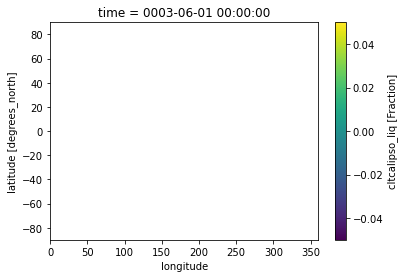

In [95]:
test4.plot()

## OLD

In [54]:
cesm2_wrap = cesm2_09res['CLDTOT_CAL'].copy()

In [52]:
cesm2_wrap.lon

<xarray.DataArray 'lon' (lon: 288)>
array([  0.  ,   1.25,   2.5 , ..., 356.25, 357.5 , 358.75])
Coordinates:
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Attributes:
    long_name:  longitude
    units:      degrees_east

In [57]:
# How do I keep the attributes?
_attrs = cesm2_wrap.lon.attrs
cesm2_wrap.assign_coords({"lon": (((cesm2_wrap.lon + 180) % 360) - 180)})
# cesm2_wrap.assign_attrs(_attrs) # why does this reverse the assign_coords

<xarray.DataArray 'CLDTOT_CAL' (time: 1, lat: 192, lon: 288)>
array([[[30.212366, 30.212366, 30.212366, ..., 30.212366, 30.212366,
         30.212366],
        [20.264517, 20.04785 , 19.762903, ..., 20.097849, 20.233334,
         20.315592],
        [16.285484, 16.1957  , 15.744086, ..., 15.835484, 15.863978,
         16.271505],
        ...,
        [73.95054 , 73.43172 , 74.043015, ..., 74.11452 , 73.719894,
         73.655914],
        [74.32903 , 74.25215 , 74.80968 , ..., 74.07527 , 74.650536,
         74.222046],
        [71.174194, 71.221504, 71.276344, ..., 71.28817 , 71.19301 ,
         71.17097 ]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... -6.25 -5.0 -3.75 -2.5 -1.25
  * time     (time) object 0003-06-01 00:00:00
Attributes:
    units:         percent
    long_name:     Lidar Total Cloud Fraction
    cell_methods:  time: mean

In [58]:
# This also converts back to the 0-360 format. I should probably keep this and modify the obs then?
cesm2_wrap.sortby(cesm2_wrap.lon)

<xarray.DataArray 'CLDTOT_CAL' (time: 1, lat: 192, lon: 288)>
array([[[30.212366, 30.212366, 30.212366, ..., 30.212366, 30.212366,
         30.212366],
        [20.264517, 20.04785 , 19.762903, ..., 20.097849, 20.233334,
         20.315592],
        [16.285484, 16.1957  , 15.744086, ..., 15.835484, 15.863978,
         16.271505],
        ...,
        [73.95054 , 73.43172 , 74.043015, ..., 74.11452 , 73.719894,
         73.655914],
        [74.32903 , 74.25215 , 74.80968 , ..., 74.07527 , 74.650536,
         74.222046],
        [71.174194, 71.221504, 71.276344, ..., 71.28817 , 71.19301 ,
         71.17097 ]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 0003-06-01 00:00:00
Attributes:
    units:         percent
    long_name:     Lidar Total Cloud Fraction
    cell_methods:  time: mean